# Use sklearn Gaussian Naive Bayes with a real student dataset

Kaggle dataset: https://www.kaggle.com/datasets/uciml/student-alcohol-consumption

In [1]:
%load_ext jupyter_black

In [2]:
import polars as pl
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Read the test dataset

In [3]:
df = pl.read_csv("../data/student_mat.csv")
df

school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,dalc,walc,health,absences,g1,g2,g3
str,str,i64,str,str,str,i64,i64,str,str,str,str,i64,i64,i64,bool,bool,bool,bool,bool,bool,bool,bool,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""GP""","""F""",18,"""U""","""GT3""","""A""",4,4,"""at_home""","""teacher""","""course""","""mother""",2,2,0,true,false,false,false,true,true,false,false,4,3,4,1,1,3,6,5,6,6
"""GP""","""F""",17,"""U""","""GT3""","""T""",1,1,"""at_home""","""other""","""course""","""father""",1,2,0,false,true,false,false,false,true,true,false,5,3,3,1,1,3,4,5,5,6
"""GP""","""F""",15,"""U""","""LE3""","""T""",1,1,"""at_home""","""other""","""other""","""mother""",1,2,3,true,false,true,false,true,true,true,false,4,3,2,2,3,3,10,7,8,10
"""GP""","""F""",15,"""U""","""GT3""","""T""",4,2,"""health""","""services""","""home""","""mother""",1,3,0,false,true,true,true,true,true,true,true,3,2,2,1,1,5,2,15,14,15
"""GP""","""F""",16,"""U""","""GT3""","""T""",3,3,"""other""","""other""","""home""","""father""",1,2,0,false,true,true,false,true,true,false,false,4,3,2,1,2,5,4,6,10,10
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""MS""","""M""",20,"""U""","""LE3""","""A""",2,2,"""services""","""services""","""course""","""other""",1,2,2,false,true,true,false,true,true,false,false,5,5,4,4,5,4,11,9,9,9
"""MS""","""M""",17,"""U""","""LE3""","""T""",3,1,"""services""","""services""","""course""","""mother""",2,1,0,false,false,false,false,false,true,true,false,2,4,5,3,4,2,3,14,16,16
"""MS""","""M""",21,"""R""","""GT3""","""T""",1,1,"""other""","""other""","""course""","""other""",1,1,3,false,false,false,false,false,true,false,false,5,5,3,3,3,3,3,10,8,7


### Rename some columns to make them more readable

In [4]:
df_2 = df.rename(
    {
        "sex": "gender",
        "famsize": "family_size",
        "pstatus": "parent_cohabit",
        "medu": "mother_education",
        "fedu": "father_education",
        "mjob": "mother_job",
        "fjob": "father_job",
        "traveltime": "travel_time",
        "studytime": "study_time",
        "failures": "num_failures",
        "schoolsup": "extra_school_support",
        "famsup": "family_support",
        "paid": "extra_paid_classes",
        "activities": "extra_curricular_activities",
        "nursery": "attended_nursery_school",
        "higher": "wants_higher_education",
        "internet": "has_internet",
        "romantic": "in_romantic_rel",
        "famrel": "family_rel_quality",
        "freetime": "free_time_amount",
        "goout": "goes_out_frequency",
        "dalc": "weekday_alcohol_consumption_amount",
        "walc": "weekend_alcohol_consumption_amount",
        "health": "quality_of_health",
        "absences": "absence_count",
    }
)
df_2 = df_2.filter(pl.col("g3") > 0)
df_2

school,gender,age,address,family_size,parent_cohabit,mother_education,father_education,mother_job,father_job,reason,guardian,travel_time,study_time,num_failures,extra_school_support,family_support,extra_paid_classes,extra_curricular_activities,attended_nursery_school,wants_higher_education,has_internet,in_romantic_rel,family_rel_quality,free_time_amount,goes_out_frequency,weekday_alcohol_consumption_amount,weekend_alcohol_consumption_amount,quality_of_health,absence_count,g1,g2,g3
str,str,i64,str,str,str,i64,i64,str,str,str,str,i64,i64,i64,bool,bool,bool,bool,bool,bool,bool,bool,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""GP""","""F""",18,"""U""","""GT3""","""A""",4,4,"""at_home""","""teacher""","""course""","""mother""",2,2,0,true,false,false,false,true,true,false,false,4,3,4,1,1,3,6,5,6,6
"""GP""","""F""",17,"""U""","""GT3""","""T""",1,1,"""at_home""","""other""","""course""","""father""",1,2,0,false,true,false,false,false,true,true,false,5,3,3,1,1,3,4,5,5,6
"""GP""","""F""",15,"""U""","""LE3""","""T""",1,1,"""at_home""","""other""","""other""","""mother""",1,2,3,true,false,true,false,true,true,true,false,4,3,2,2,3,3,10,7,8,10
"""GP""","""F""",15,"""U""","""GT3""","""T""",4,2,"""health""","""services""","""home""","""mother""",1,3,0,false,true,true,true,true,true,true,true,3,2,2,1,1,5,2,15,14,15
"""GP""","""F""",16,"""U""","""GT3""","""T""",3,3,"""other""","""other""","""home""","""father""",1,2,0,false,true,true,false,true,true,false,false,4,3,2,1,2,5,4,6,10,10
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""MS""","""M""",20,"""U""","""LE3""","""A""",2,2,"""services""","""services""","""course""","""other""",1,2,2,false,true,true,false,true,true,false,false,5,5,4,4,5,4,11,9,9,9
"""MS""","""M""",17,"""U""","""LE3""","""T""",3,1,"""services""","""services""","""course""","""mother""",2,1,0,false,false,false,false,false,true,true,false,2,4,5,3,4,2,3,14,16,16
"""MS""","""M""",21,"""R""","""GT3""","""T""",1,1,"""other""","""other""","""course""","""other""",1,1,3,false,false,false,false,false,true,false,false,5,5,3,3,3,3,3,10,8,7


### Clean up the data a little

In [5]:
# Use a LabelEncoder
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
le = LabelEncoder()

# List of columns that need to be assigned numeric values
columns_to_encode = [
    "school",
    "gender",
    "address",
    "family_size",
    "parent_cohabit",
    "mother_job",
    "father_job",
    "reason",
    "guardian",
]

# Convert values in the columns that should be encoded into encoded values
pl_series = [
    pl.Series(feature + "_num", le.fit_transform(df_2[feature]))
    for feature in columns_to_encode
]

# Create a new dataframe with the encoded data and the sample data
df_3 = df_2.with_columns(pl_series)

# Try categorizing absences into a new column
df_3 = df_3.with_columns(
    pl.when(pl.col("absence_count") <= 5)
    .then(0)
    .when((pl.col("absence_count") > 5) & (pl.col("absence_count") <= 10))
    .then(1)
    .when((pl.col("absence_count") > 10) & (pl.col("absence_count") <= 15))
    .then(2)
    .when((pl.col("absence_count") > 15) & (pl.col("absence_count") <= 20))
    .then(3)
    .otherwise(4)
    .cast(pl.Int64)
    .alias("absence_category"),
)
df_3

school,gender,age,address,family_size,parent_cohabit,mother_education,father_education,mother_job,father_job,reason,guardian,travel_time,study_time,num_failures,extra_school_support,family_support,extra_paid_classes,extra_curricular_activities,attended_nursery_school,wants_higher_education,has_internet,in_romantic_rel,family_rel_quality,free_time_amount,goes_out_frequency,weekday_alcohol_consumption_amount,weekend_alcohol_consumption_amount,quality_of_health,absence_count,g1,g2,g3,school_num,gender_num,address_num,family_size_num,parent_cohabit_num,mother_job_num,father_job_num,reason_num,guardian_num,absence_category
str,str,i64,str,str,str,i64,i64,str,str,str,str,i64,i64,i64,bool,bool,bool,bool,bool,bool,bool,bool,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""GP""","""F""",18,"""U""","""GT3""","""A""",4,4,"""at_home""","""teacher""","""course""","""mother""",2,2,0,true,false,false,false,true,true,false,false,4,3,4,1,1,3,6,5,6,6,0,0,1,0,0,0,4,0,1,1
"""GP""","""F""",17,"""U""","""GT3""","""T""",1,1,"""at_home""","""other""","""course""","""father""",1,2,0,false,true,false,false,false,true,true,false,5,3,3,1,1,3,4,5,5,6,0,0,1,0,1,0,2,0,0,0
"""GP""","""F""",15,"""U""","""LE3""","""T""",1,1,"""at_home""","""other""","""other""","""mother""",1,2,3,true,false,true,false,true,true,true,false,4,3,2,2,3,3,10,7,8,10,0,0,1,1,1,0,2,2,1,1
"""GP""","""F""",15,"""U""","""GT3""","""T""",4,2,"""health""","""services""","""home""","""mother""",1,3,0,false,true,true,true,true,true,true,true,3,2,2,1,1,5,2,15,14,15,0,0,1,0,1,1,3,1,1,0
"""GP""","""F""",16,"""U""","""GT3""","""T""",3,3,"""other""","""other""","""home""","""father""",1,2,0,false,true,true,false,true,true,false,false,4,3,2,1,2,5,4,6,10,10,0,0,1,0,1,2,2,1,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""MS""","""M""",20,"""U""","""LE3""","""A""",2,2,"""services""","""services""","""course""","""other""",1,2,2,false,true,true,false,true,true,false,false,5,5,4,4,5,4,11,9,9,9,1,1,1,1,0,3,3,0,2,2
"""MS""","""M""",17,"""U""","""LE3""","""T""",3,1,"""services""","""services""","""course""","""mother""",2,1,0,false,false,false,false,false,true,true,false,2,4,5,3,4,2,3,14,16,16,1,1,1,1,1,3,3,0,1,0
"""MS""","""M""",21,"""R""","""GT3""","""T""",1,1,"""other""","""other""","""course""","""other""",1,1,3,false,false,false,false,false,true,false,false,5,5,3,3,3,3,3,10,8,7,1,1,0,0,1,2,2,0,2,0


### Create a function to do the training and test and return the accuracy so i don't need to copy and paste over and over

In [24]:
from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
import statistics
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression  # or your preferred model


columns_to_keep = set()
df_3.schema.to_python()
for k, v in df_3.schema.to_python().items():
    if v != str:
        columns_to_keep.add(k)
    else:
        print(f"will drop: {k}")
columns_to_drop = (set(df_3.columns) - columns_to_keep) | {"g1", "g2", "g3"}

X = df_3.drop(columns_to_drop)
y = df_3["g3"]

quantile_transformer = preprocessing.QuantileTransformer(
    output_distribution="normal",
    random_state=0,
    n_quantiles=df_3.shape[0],
)
X_trans = quantile_transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_trans,
    y,
    test_size=0.05,  # train_size=0.999
)

lasso = linear_model.Lasso()
cv_results = cross_validate(lasso, X, y, cv=None)

sorted(cv_results.keys())
cv_results["test_score"]
print(cv_results)

print(statistics.mean(cv_results["test_score"]))
print(statistics.stdev(cv_results["test_score"]))

will drop: school
will drop: gender
will drop: address
will drop: family_size
will drop: parent_cohabit
will drop: mother_job
will drop: father_job
will drop: reason
will drop: guardian
{'fit_time': array([0.00199914, 0.00099826, 0.00204992, 0.00195074, 0.00096989]), 'score_time': array([0.0010004 , 0.00100136, 0.        , 0.00102973, 0.00099874]), 'test_score': array([0.02522376, 0.03523635, 0.02824287, 0.02575453, 0.00222854])}
0.023337208437393665
0.012456259751913295


### Experiment with using the StandardScalar and linear regression
Also plot the results

will drop: school
will drop: gender
will drop: address
will drop: family_size
will drop: parent_cohabit
will drop: mother_job
will drop: father_job
will drop: reason
will drop: guardian
The R² score (model.score) on the test data is: 0.9316885485269282
Mean Squared Error: 0.6693573474201686
Mean Absolute Error (MAE): 0.5653


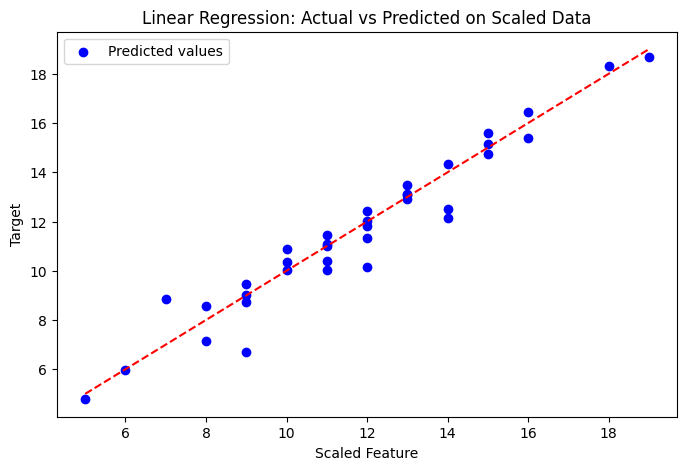

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


columns_to_keep = set()
df_3.schema.to_python()
for k, v in df_3.schema.to_python().items():
    if v != str:
        columns_to_keep.add(k)
    else:
        print(f"will drop: {k}")
columns_to_drop = (set(df_3.columns) - columns_to_keep) | {"g3"}

X = df_3.drop(columns_to_drop)
y = df_3["g3"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.9, random_state=42
)

# Initialize StandardScaler and scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate and train the LinearRegression model on the scaled data
model = LinearRegression()
model.fit(X_train_scaled, y_train)

score = model.score(X_test_scaled, y_test)
print("The R² score (model.score) on the test data is:", score)

# Making predictions on the scaled test data
y_pred = model.predict(X_test_scaled)

# Evaluate the model performance using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)

# Display results
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Optionally, visualize the results
plt.figure(figsize=(8, 5))
# plt.scatter(X_test_scaled, y_test, color="red", label="Actual values")
plt.scatter(y_test, y_pred, color="blue", label="Predicted values")
plt.plot(
    [min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--"
)  # Ideal line

plt.xlabel("Scaled Feature")
plt.ylabel("Target")
plt.title("Linear Regression: Actual vs Predicted on Scaled Data")
plt.legend()
plt.show()

### Experiment with stacking classifiers
Try using Gaussian Naive Bayes and linear regression together

will drop: school
will drop: gender
will drop: address
will drop: family_size
will drop: parent_cohabit
will drop: mother_job
will drop: father_job
will drop: reason
will drop: guardian
average accuracy: 0.2222222222222222


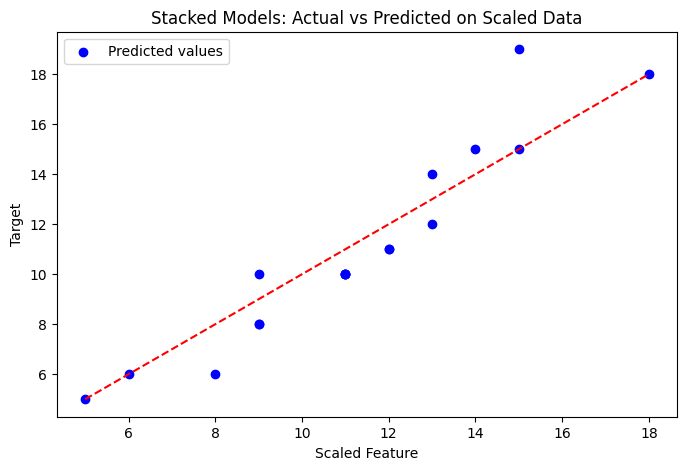

In [29]:
from sklearn import preprocessing
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    columns_to_keep = set()
    df_3.schema.to_python()
    for k, v in df_3.schema.to_python().items():
        if v != str:
            columns_to_keep.add(k)
        else:
            print(f"will drop: {k}")
    columns_to_drop = (set(df_3.columns) - columns_to_keep) | {"g3"}

    X = df_3.drop(columns_to_drop)
    y = df_3["g3"]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.05,  # train_size=0.999
        random_state=42,
        shuffle=True,
    )

    # Initialize the Gaussian Naive Bayes classifier
    gnb = GaussianNB()
    lr = LinearRegression()
    stacking_model = StackingClassifier(
        estimators=[("gnb", gnb), ("lr", lr)],
        final_estimator=LogisticRegression(),  # The meta-classifier
        cv=None,  # Use cross-validation to generate out-of-fold predictions
    )

    # Train the model
    stacking_model.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = stacking_model.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"average accuracy: {accuracy}")

    # Optionally, visualize the results
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test, y_pred, color="blue", label="Predicted values")
    plt.plot(
        [min(y_test), max(y_test)],
        [min(y_test), max(y_test)],
        color="red",
        linestyle="--",
    )  # Ideal line

    plt.xlabel("Scaled Feature")
    plt.ylabel("Target")
    plt.title("Stacked Models: Actual vs Predicted on Scaled Data")
    plt.legend()
    plt.show()

### Introduce QuantileTransformer with the same stacked model

will drop: school
will drop: gender
will drop: address
will drop: family_size
will drop: parent_cohabit
will drop: mother_job
will drop: father_job
will drop: reason
will drop: guardian
average accuracy: 0.05555555555555555


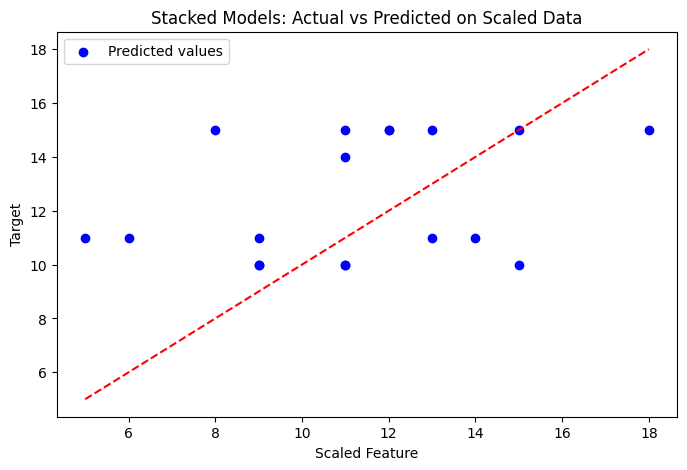

In [30]:
from sklearn import preprocessing
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    columns_to_keep = set()
    df_3.schema.to_python()
    for k, v in df_3.schema.to_python().items():
        if v != str:
            columns_to_keep.add(k)
        else:
            print(f"will drop: {k}")
    columns_to_drop = (set(df_3.columns) - columns_to_keep) | {"g3"}

    X = df_3.drop(columns_to_drop)
    y = df_3["g3"]

    X_train, X_test, y_train, y_test = train_test_split(
        X_trans,
        y,
        test_size=0.05,  # train_size=0.999
        random_state=42,
        shuffle=True,
    )

    # apply a quantile transformer after splitting so that there is no data leakage
    # into the test data
    quantile_transformer = preprocessing.QuantileTransformer(
        output_distribution="normal",
        random_state=0,
        n_quantiles=df_3.shape[0],
    )
    X_train_transformed = quantile_transformer.fit_transform(X_train)
    X_test_transformed = quantile_transformer.transform(X_test)

    # Initialize the Gaussian Naive Bayes classifier
    gnb = GaussianNB()
    lr = LinearRegression()
    stacking_model = StackingClassifier(
        estimators=[("gnb", gnb), ("lr", lr)],
        final_estimator=LogisticRegression(),  # The meta-classifier
        cv=None,  # Use cross-validation to generate out-of-fold predictions
    )

    # Train the model
    stacking_model.fit(X_train_transformed, y_train)

    # Predict the labels for the test set
    y_pred = stacking_model.predict(X_test_transformed)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"average accuracy: {accuracy}")

    # Optionally, visualize the results
    plt.figure(figsize=(8, 5))
    # plt.scatter(X_test_scaled, y_test, color="red", label="Actual values")
    plt.scatter(y_test, y_pred, color="blue", label="Predicted values")
    plt.plot(
        [min(y_test), max(y_test)],
        [min(y_test), max(y_test)],
        color="red",
        linestyle="--",
    )  # Ideal line

    plt.xlabel("Scaled Feature")
    plt.ylabel("Target")
    plt.title("Stacked Models: Actual vs Predicted on Scaled Data")
    plt.legend()
    plt.show()

### Stack Gaussian Naive Bayes with logistic regression

will drop: school
will drop: gender
will drop: address
will drop: family_size
will drop: parent_cohabit
will drop: mother_job
will drop: father_job
will drop: reason
will drop: guardian
average accuracy: 0.2777777777777778


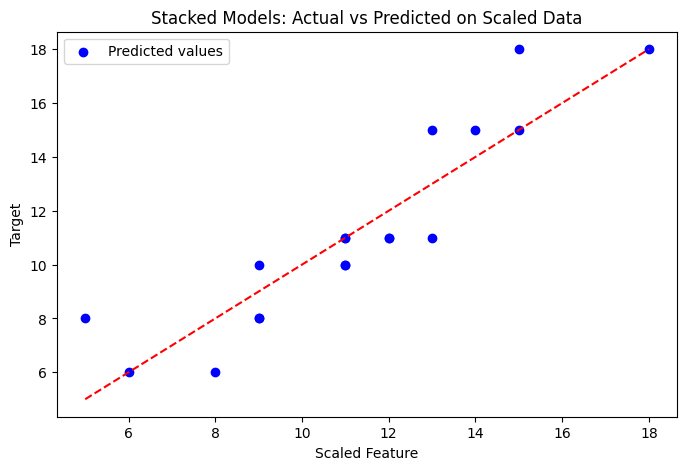

In [31]:
from sklearn import preprocessing
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    columns_to_keep = set()
    df_3.schema.to_python()
    for k, v in df_3.schema.to_python().items():
        if v != str:
            columns_to_keep.add(k)
        else:
            print(f"will drop: {k}")
    columns_to_drop = (set(df_3.columns) - columns_to_keep) | {"g3"}

    X = df_3.drop(columns_to_drop)
    y = df_3["g3"]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.05,  # train_size=0.999
        random_state=42,
        shuffle=True,
    )

    # Initialize the Gaussian Naive Bayes classifier
    gnb = GaussianNB()
    lr = LogisticRegression(max_iter=100)
    stacking_model = StackingClassifier(
        estimators=[("gnb", gnb), ("lr", lr)],
        final_estimator=LogisticRegression(),  # The meta-classifier
        cv=None,  # Use cross-validation to generate out-of-fold predictions
    )

    # Train the model
    stacking_model.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = stacking_model.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"average accuracy: {accuracy}")

    # Optionally, visualize the results
    plt.figure(figsize=(8, 5))
    # plt.scatter(X_test_scaled, y_test, color="red", label="Actual values")
    plt.scatter(y_test, y_pred, color="blue", label="Predicted values")
    plt.plot(
        [min(y_test), max(y_test)],
        [min(y_test), max(y_test)],
        color="red",
        linestyle="--",
    )  # Ideal line

    plt.xlabel("Scaled Feature")
    plt.ylabel("Target")
    plt.title("Stacked Models: Actual vs Predicted on Scaled Data")
    plt.legend()
    plt.show()

### Create a function to do the training and test and return the accuracy so i don't need to copy and paste over and over
This is a modification of my earlier function to use a StackingClassifier with Gaussian Naive Bayes and Logistic Regression

In [9]:
def fit_and_test(
    df: pl.DataFrame,
    columns_to_drop: list[str],
    category_column: str,
    log: bool = False,
    return_gnb: bool = False,
    count: int = 10,
    do_plot: bool = True,
) -> float:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Extract features and labels
        X = df.drop(columns_to_drop)
        y = df[category_column]
        accuracy_seen = []

        for i in range(count):
            # Split the dataset into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y,
                test_size=0.05,  # train_size=0.999
            )

            # Initialize the Gaussian Naive Bayes classifier
            gnb = GaussianNB()
            lr = LogisticRegression(max_iter=100)
            stacking_model = StackingClassifier(
                estimators=[("gnb", gnb), ("lr", lr)],
                final_estimator=LogisticRegression(),  # The meta-classifier
                cv=5,  # Use cross-validation to generate out-of-fold predictions
            )

            # Train the model
            stacking_model.fit(X_train, y_train)

            # Predict the labels for the test set
            y_pred = stacking_model.predict(X_test)
            if log:
                print(f"Predicted values: {y_pred}")

            # Calculate the accuracy
            accuracy = accuracy_score(y_test, y_pred)
            # print(f"Accuracy: {accuracy}")
            accuracy_seen.append(accuracy)

            if i == count - 1:
                # Optionally, visualize the results
                plt.figure(figsize=(8, 5))
                # plt.scatter(X_test_scaled, y_test, color="red", label="Actual values")
                plt.scatter(y_test, y_pred, color="blue", label="Predicted values")
                plt.plot(
                    [min(y_test), max(y_test)],
                    [min(y_test), max(y_test)],
                    color="red",
                    linestyle="--",
                )  # Ideal line

                plt.xlabel("Scaled Feature")
                plt.ylabel("Target")
                plt.title("Linear Regression: Actual vs Predicted on Scaled Data")
                plt.legend()
                plt.show()

        average_accuracy = sum(accuracy_seen) / count
        if log:
            print(f"average accuracy: {average_accuracy}")

        if return_gnb:
            return (average_accuracy, gnb)
        else:
            return average_accuracy

### Check the accuracy when using all data

will drop: school
will drop: gender
will drop: address
will drop: family_size
will drop: parent_cohabit
will drop: mother_job
will drop: father_job
will drop: reason
will drop: guardian


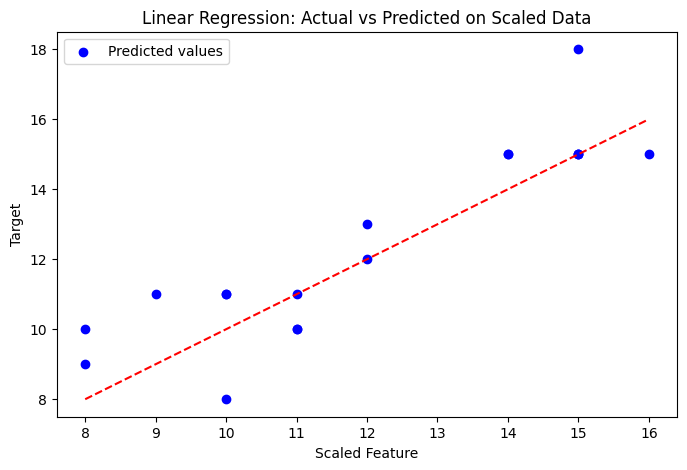

0.2777777777777778

In [10]:
columns_to_keep = set()

df_3.schema.to_python()
for k, v in df_3.schema.to_python().items():
    if v != str:
        columns_to_keep.add(k)
    else:
        print(f"will drop: {k}")
columns_to_drop = (set(df_3.columns) - columns_to_keep) | {"g3"}

fit_and_test(df_3, columns_to_drop, "g3", count=1)

### I picked some columns i liked to see how good they are
This isn't as good as using the entire dataset

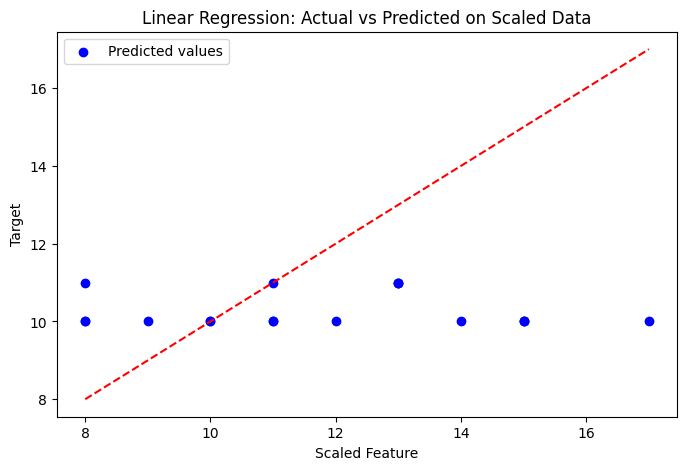

0.11111111111111112

In [11]:
columns_to_keep = {
    "weekday_alcohol_consumption_amount",
    "weekend_alcohol_consumption_amount",
    "quality_of_health",
    "absence_count",
    "study_time",
    "extra_paid_classes_num",
    "extra_school_support_num",
    "has_internet_num",
}

columns_to_drop = set(df_3.columns) - columns_to_keep

fit_and_test(df_3, columns_to_drop, "g3")

### I tried adding a few more
This still isn't as good as using the entire dataset

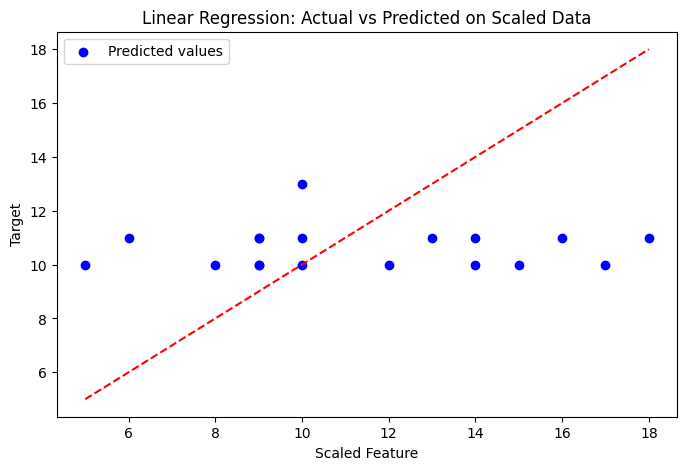

0.1222222222222222

In [12]:
columns_to_keep = {
    "weekday_alcohol_consumption_amount",
    "weekend_alcohol_consumption_amount",
    "quality_of_health",
    "absence_count",
    "study_time",
    "extra_paid_classes_num",
    "extra_school_support_num",
    "family_support_num",
    "has_internet_num",
    "father_job_num",
    "mother_job_num",
}

columns_to_drop = set(df_3.columns) - columns_to_keep

fit_and_test(df_3, columns_to_drop, "g3")

### I picked the best five features identified by my earlier notebook

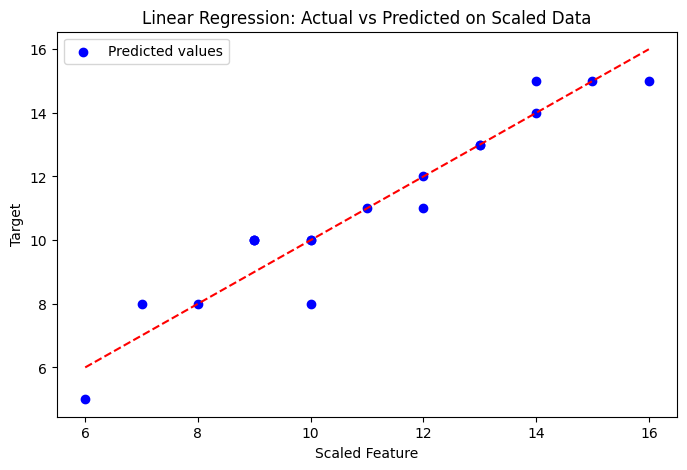

0.45

In [13]:
columns_to_keep = {
    "free_time_amount",
    "goes_out_frequency",
    "quality_of_health",
    "reason_num",
    "g1",
    "g2",
}

columns_to_drop = set(df_3.columns) - columns_to_keep

fit_and_test(df_3, columns_to_drop, "g3")

### I picked one of the best four features identified by my earlier notebook

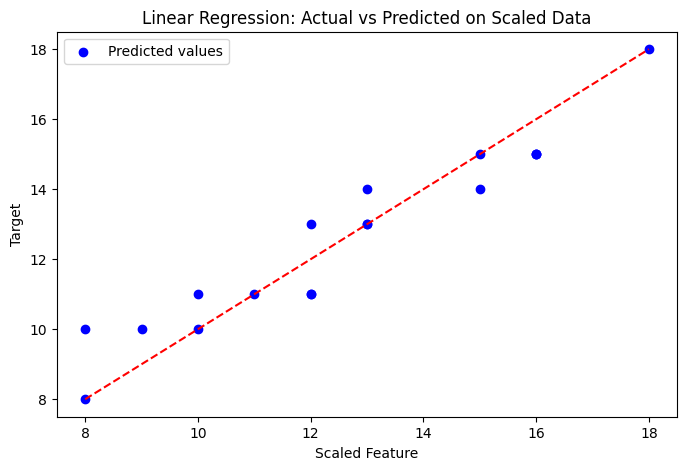

0.4666666666666667

In [15]:
columns_to_keep = {
    "travel_time",
    "extra_paid_classes",
    "weekend_alcohol_consumption_amount",
    "quality_of_health",
    "g2",
}

columns_to_drop = set(df_3.columns) - columns_to_keep

fit_and_test(df_3, columns_to_drop, "g3")

### I picked another of the best five features identified by my earlier notebook

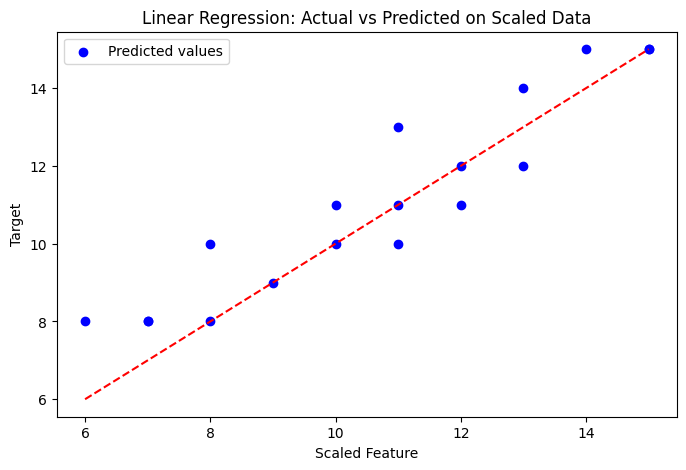

0.4833333333333333

In [14]:
columns_to_keep = {
    "extra_curricular_activities",
    "weekend_alcohol_consumption_amount",
    "father_job_num",
    "absence_category",
    "g1",
    "g2",
}

columns_to_drop = set(df_3.columns) - columns_to_keep

fit_and_test(df_3, columns_to_drop, "g3")